# CPE 646
# Final Project
# Name: Minh Quang Duong
# Email ID: mduong@stevens.edu
# CWID: 20030957


In [52]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import zipfile
import os


In [2]:
#Extract and list files
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')
    
print("Files extracted to 'extracted_files' folder")

for root, dirs, files_list in os.walk('extracted_files'):
    for file in files_list:
        print(os.path.join(root, file))

Files extracted to 'extracted_files' folder
extracted_files\analyze_data.py
extracted_files\calculate_metrics.py
extracted_files\extract_words.py
extracted_files\GoEmotionsFormat.PNG
extracted_files\goemotions_model_card.pdf
extracted_files\README.md
extracted_files\replace_emotions.py
extracted_files\data\dev.tsv
extracted_files\data\ekman_labels.csv
extracted_files\data\ekman_mapping.json
extracted_files\data\emotions.txt
extracted_files\data\sentiment_dict.json
extracted_files\data\sentiment_mapping.json
extracted_files\data\test.tsv
extracted_files\data\train.tsv
extracted_files\data\full_dataset\goemotions_1.csv
extracted_files\data\full_dataset\goemotions_2.csv
extracted_files\data\full_dataset\goemotions_3.csv
extracted_files\plots\colors.tsv
extracted_files\plots\correlations.pdf
extracted_files\plots\hierarchical_clustering.pdf
extracted_files\plots\hierarchical_corr.pdf
extracted_files\plots\number_of_labels.pdf
extracted_files\tables\emotion_words.csv


                                                Text emotion_id       id
0  My favourite food is anything I didn't have to...         27  eebbqej
1  Now if he does off himself, everyone will thin...         27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING          2  eezlygj
3                        To make her feel threatened         14  ed7ypvh
4                             Dirty Southern Wankers          3  ed0bdzj
                                                   Text emotion_id       id
0     I’m really sorry about your situation :( Altho...         25  eecwqtt
1       It's wonderful because it's awful. At not with.          0  ed5f85d
2     Kings fan here, good luck to you guys! Will be...         13  een27c3
3     I didn't know that, thank you for teaching me ...         15  eelgwd1
4     They got bored from haunting earth for thousan...         27  eem5uti
...                                                 ...        ...      ...
5422  Thanks. I was diagnosed 

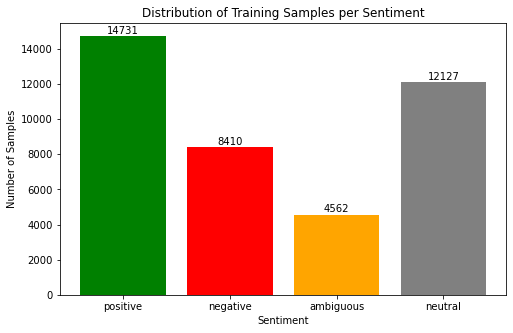

In [54]:
#Inspect Data
train_data = pd.read_csv('extracted_files/data/train.tsv', sep = '\t',header = None, names = ['Text', 'emotion_id', 'id'])
test_data = pd.read_csv('extracted_files/data/test.tsv', sep = '\t',header = None, names = ['Text', 'emotion_id', 'id'])
print(train_data.head())
print(test_data)
print(train_data.count())
multi_label_mask = train_data['emotion_id'].astype(str).str.contains(',')
multi_label_rows = train_data[multi_label_mask]

print(f"Total rows with multiple emotions: {len(multi_label_rows)}")

#Load emotion labels
with open('extracted_files/data/emotions.txt', 'r') as f:
    emotions = [line.strip() for line in f.readlines()]
with open('extracted_files/data/sentiment_dict.json', 'r') as f:
    sentiment_map = json.load(f)
print(emotions)
print(sentiment_map)
sentiment_map.update({"neutral": "neutral"})
sentiment_classes = list(sentiment_map.keys())
print(sentiment_classes)
NUM_CLASSES = len(sentiment_classes)


emotion_idx_to_sentiment_idx = {}
for emotion_idx, emotion_name in enumerate(emotions):
    found = False
    for sent_idx, sent_name in enumerate(sentiment_classes):
        if emotion_name in sentiment_map[sent_name]:
            emotion_idx_to_sentiment_idx[emotion_idx] = sent_idx
            found = True
            break
    if not found:
        print(f"Warning: {emotion_name} not found in any sentiment group!")
print(f"Mapped {len(emotion_idx_to_sentiment_idx)} emotions to {NUM_CLASSES} sentiment classes.\n")

#Inspect emotion mapping index
for emotion_idx, emotion_name in enumerate(emotions):
    if emotion_idx in emotion_idx_to_sentiment_idx:
        sent_idx = emotion_idx_to_sentiment_idx[emotion_idx]
        sent_name = sentiment_classes[sent_idx]
        
        print(f"{emotion_idx:<12} {emotion_name:<20} {sent_idx:<15} {sent_name}")
    else:
        print(f"{emotion_idx:<12} {emotion_name:<20} {'MISSING':<15} {'MISSING'}")

#Plot sentiment classes distribution
class_counts = np.sum(y_train, axis=0)
plt.figure(figsize=(8, 5))
bars = plt.bar(sentiment_classes, class_counts, color=['green', 'red', 'orange', 'gray'])

plt.title('Distribution of Training Samples per Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, int(yval), ha='center', va='bottom')

plt.show()


#Check for missing values
print(f"\nMissing values in training data:\n{train_data.isnull().sum()}")

#Emotion distribution
emotion_counts = train_data['emotion_id'].apply(
    lambda x: int(str(x).split(',')[0])
).value_counts().sort_index()
print(f"\nEmotion distribution:\n{emotion_counts}")

#Plot emotion distribution
plt.figure(figsize=(14, 6))
emotion_names = [emotions[i] if i < len(emotions) else f"Emotion_{i}" 
                 for i in emotion_counts.index]
plt.bar(emotion_names, emotion_counts.values, color='steelblue')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Emotions in Training Data', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('emotion_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [53]:
#Data cleaning
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower() #Convert lower case
    text = re.sub(r'http\S+', '', text) #Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) #Remove special chars w/o basic punctuation
    text = re.sub(r'\s+', ' ', text).strip() #Remove white noise
    return text

train_data['cleaned_text'] = train_data['Text'].apply(clean_text)
test_data['cleaned_text'] = test_data['Text'].apply(clean_text)

In [11]:
#Tokenization
MAX_WORDS = 10000
MAX_LEN = 100
EMBEDDING_DIM = 128

print("\nTokenizing text...")
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['cleaned_text'])
#Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['cleaned_text'])


#Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Shape of X train: {X_train_pad.shape}")
print(f"Shape of X test: {X_test_pad.shape}")

#Convert to multi-label binary format
def emotion_to_sentiment_vector(emotion_id_str, num_classes=4):
    label_vector = np.zeros(num_classes, dtype=np.float32)
    
    try:
        
        if isinstance(emotion_id_str, str) and ',' in emotion_id_str:
            emotion_ids = [int(x.strip()) for x in emotion_id_str.split(',')]
        else:
            emotion_ids = [int(emotion_id_str)]
        
        for eid in emotion_ids:
            if eid in emotion_idx_to_sentiment_idx:
                sent_idx = emotion_idx_to_sentiment_idx[eid]
                label_vector[sent_idx] = 1.0
                
    except Exception as e:
        print(f"Error parsing emotion_id '{emotion_id_str}': {e}")
    
    return label_vector
y_train = np.array([emotion_to_sentiment_vector(eid, NUM_CLASSES) 
                    for eid in train_data['emotion_id']])
y_test = np.array([emotion_to_sentiment_vector(eid, NUM_CLASSES) 
                   for eid in test_data['emotion_id']])    

X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.15, random_state=42, shuffle=True)
print(f"Shape of Y train: {y_train.shape}")
print(f"Shape of Y test: {y_test.shape}")


Tokenizing text...
Vocabulary size: 27275
Shape of X train: (43410, 100)
Shape of X test: (5427, 100)
Shape of Y train: (36898, 4)
Shape of Y test: (5427, 4)


In [26]:
#Calculate Class Weights
class_counts = np.sum(y_train, axis=0) 
total_samples = len(y_train)

print(f"Counts per class: {class_counts}")


class_weights = {}
for i in range(NUM_CLASSES):
    
    if class_counts[i] > 0:
        class_weights[i] = total_samples / (NUM_CLASSES * class_counts[i])
    else:
        class_weights[i] = 1.0 

print("\nComputed Class Weights:")
for i, name in enumerate(sentiment_classes):
    print(f"{name}: {class_weights[i]:.4f}")

Counts per class: [14731.  8410.  4562. 12127.]

Computed Class Weights:
positive: 0.6262
negative: 1.0968
ambiguous: 2.0220
neutral: 0.7607


In [60]:
#Model 1: Convolutional Neural Network (CNN) for text classification
def create_cnn_model(max_words=10000, max_len=100, embedding_dim=128, num_classes=2):
    model = keras.Sequential([
        layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        layers.SpatialDropout1D(0.4), 

        layers.Conv1D(filters=128, kernel_size=2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=128, kernel_size=3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=128, kernel_size=4),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalMaxPooling1D(),

        layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),  
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model
 
#Model 2.1: Bi-directional Long Shot Term Memoty (BILSTM) with 2 layers 
def create_bilstm_model_1(max_words=10000, max_len=100, embedding_dim=128, num_classes=2):

    model = keras.Sequential([
        layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        layers.SpatialDropout1D(0.3),

        layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.2)),
        
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model


#Model 2.2: Bi-directional Long Shot Term Memoty (BILSTM) with 2 layers 
def create_bilstm_model_2(max_words=10000, max_len=100, embedding_dim=128, num_classes=2):
    model = keras.Sequential([
        layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        layers.SpatialDropout1D(0.3),

        layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)),
        layers.Dropout(0.2),
        layers.Bidirectional(layers.LSTM(64)),

        layers.Dropout(0.2),

        
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model


In [28]:
def compile_and_train(model, X_train, y_train, X_val, y_val, num_classes=4, epochs=10, batch_size=256,class_weight=None):
    #Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
    #Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)]
    #Train model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight,   
        verbose=1)
    return history


In [29]:
#Create and train CNN model
model_cnn = create_cnn_model(MAX_WORDS, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES)
history_cnn = compile_and_train(
    model_cnn, 
    X_train, y_train, 
    X_val, y_val,
    num_classes=NUM_CLASSES, 
    epochs=20,
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/20


C:\Users\t0m\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1154/1154 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.3408 - loss: 0.8290 - val_accuracy: 0.5717 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 2/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.5608 - loss: 0.4384 - val_accuracy: 0.6434 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 3/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6515 - loss: 0.3812 - val_accuracy: 0.6479 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 4/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6889 - loss: 0.3476 - val_accuracy: 0.6387 - val_loss: 0.4095 - learning_rate: 0.0010
Epoch 5/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7268 - loss: 0.3183 - val_accuracy: 0.6169 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 6/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.7642 - loss: 0.2786 - val_accuracy: 0.6354 - val_loss: 0.4290 - learning_rate: 5.0000e-04


In [34]:
#Evaluate CNN model on test set
y_pred_probs_cnn = model_cnn.predict(X_test_pad)
y_pred_binary = (y_pred_probs_cnn > 0.2).astype(int)

test_loss_cnn, test_acc_cnn  = model_cnn.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nTest Loss: {test_loss_cnn:.4f}")
print(f"Test Accuracy: {test_acc_cnn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=sentiment_classes, zero_division=0))

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Loss: 0.4100
Test Accuracy: 0.6352

Classification Report:
              precision    recall  f1-score   support

    positive       0.74      0.80      0.77      2104
    negative       0.45      0.82      0.58      1262
   ambiguous       0.28      0.71      0.40       677
     neutral       0.48      0.91      0.63      1787

   micro avg       0.50      0.83      0.62      5830
   macro avg       0.49      0.81      0.60      5830
weighted avg       0.54      0.83      0.64      5830
 samples avg       0.59      0.84      0.66      5830



In [61]:
#Create and train BiLSTM.1 model
model_bilstm_1 = create_bilstm_model_1(MAX_WORDS, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES)
history_bilstm_1 = compile_and_train(
    model_bilstm_1, 
    X_train, y_train, 
    X_val, y_val,
    num_classes=NUM_CLASSES, 
    epochs=20,
    batch_size=32,
    #class_weight=class_weights

)

Epoch 1/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 75s 61ms/step - accuracy: 0.4430 - loss: 0.6948 - val_accuracy: 0.5782 - val_loss: 0.4521 - learning_rate: 0.0010
Epoch 2/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - accuracy: 0.6125 - loss: 0.4450 - val_accuracy: 0.6513 - val_loss: 0.4204 - learning_rate: 0.0010
Epoch 3/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 71s 62ms/step - accuracy: 0.6724 - loss: 0.4077 - val_accuracy: 0.6476 - val_loss: 0.4143 - learning_rate: 0.0010
Epoch 4/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 69s 60ms/step - accuracy: 0.6896 - loss: 0.3872 - val_accuracy: 0.6465 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 5/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 70s 61ms/step - accuracy: 0.7126 - loss: 0.3670 - val_accuracy: 0.6448 - val_loss: 0.4147 - learning_rate: 0.0010
Epoch 6/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 69s 60ms/step - accuracy: 0.7283 - loss: 0.3478 - val_accuracy: 0.6440 - val_loss: 0.4302 - learning_rate: 5.0000e-04


In [62]:
#Evaluate BiLSTM.1 model on test set
y_pred_probs_bilstm_1 = model_bilstm_1.predict(X_test_pad)
y_pred_bilstm_1 = (y_pred_probs_bilstm_1 > 0.3).astype(int)
test_loss_bilstm_1, test_acc_bilstm_1  = model_bilstm_1.evaluate(X_test_pad, y_test, verbose=0)

print(f"\nTest Loss: {test_loss_bilstm_1:.4f}")
print(f"Test Accuracy: {test_acc_bilstm_1:4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bilstm_1, target_names=sentiment_classes, zero_division=0))


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

Test Loss: 0.4189
Test Accuracy: 0.634973

Classification Report:
              precision    recall  f1-score   support

    positive       0.75      0.79      0.77      2104
    negative       0.56      0.64      0.59      1262
   ambiguous       0.00      0.00      0.00       677
     neutral       0.52      0.87      0.65      1787

   micro avg       0.61      0.69      0.64      5830
   macro avg       0.46      0.57      0.50      5830
weighted avg       0.55      0.69      0.61      5830
 samples avg       0.65      0.70      0.66      5830



In [63]:
#Create and train BiLSTM.2 model
model_bilstm_2 = create_bilstm_model_2(MAX_WORDS, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES)
history_bilstm_2 = compile_and_train(
    model_bilstm_2, 
    X_train, y_train, 
    X_val, y_val,
    num_classes=NUM_CLASSES, 
    epochs=20,
    batch_size=32,
    class_weight=class_weights

)

Epoch 1/20


C:\Users\t0m\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1154/1154 ━━━━━━━━━━━━━━━━━━━━ 103s 83ms/step - accuracy: 0.3781 - loss: 0.6750 - val_accuracy: 0.5627 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 2/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 96s 83ms/step - accuracy: 0.5784 - loss: 0.4344 - val_accuracy: 0.6144 - val_loss: 0.4439 - learning_rate: 0.0010
Epoch 3/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 96s 83ms/step - accuracy: 0.6543 - loss: 0.3966 - val_accuracy: 0.6457 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 4/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 99s 85ms/step - accuracy: 0.6985 - loss: 0.3563 - val_accuracy: 0.6471 - val_loss: 0.4075 - learning_rate: 0.0010
Epoch 5/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 100s 87ms/step - accuracy: 0.7228 - loss: 0.3366 - val_accuracy: 0.6493 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 6/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 94s 82ms/step - accuracy: 0.7348 - loss: 0.3199 - val_accuracy: 0.6473 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 7/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 94s 82ms/step - accuracy: 0.761

In [64]:
#Evaluate BiLSTM.2 model on test set
y_pred_probs_bilstm_2 = model_bilstm_2.predict(X_test_pad)
y_pred_bilstm_2 = (y_pred_probs_bilstm_2 > 0.3).astype(int)
test_loss_bilstm_2, test_acc_bilstm_2  = model_bilstm_2.evaluate(X_test_pad, y_test, verbose=0)


# Classification report
print(f"\nTest Loss: {test_loss_bilstm_2:.4f}")
print(f"Test Accuracy: {test_acc_bilstm_2:4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bilstm_2, target_names=sentiment_classes, zero_division=0))


170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step

Test Loss: 0.4133
Test Accuracy: 0.640501

Classification Report:
              precision    recall  f1-score   support

    positive       0.81      0.73      0.77      2104
    negative       0.58      0.66      0.62      1262
   ambiguous       0.41      0.55      0.47       677
     neutral       0.55      0.76      0.64      1787

   micro avg       0.61      0.70      0.65      5830
   macro avg       0.59      0.67      0.62      5830
weighted avg       0.64      0.70      0.66      5830
 samples avg       0.66      0.72      0.67      5830

